# Documentation 3.3. Dementia Image Data Recognition based on Transfer Learning

Since our training data size is small, the performance in Documentation 3.2 is very bad. We will try to use transfer learning in this section, which means we will use a pre-trained model to train our model. Also, we use PyTorch in this section.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
datadir = '/content/drive/My Drive/STAT8021/project/dementia_data/'
traindir = datadir + 'train/'
validdir = datadir + 'val/'
testdir = datadir + 'test/'
save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

batch_size = 64

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


## Part 1: The number of images in each category.

In [4]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})
cat_df

,category,n_train,n_valid,n_test
1,dementia,359,145,49
0,normal,330,149,49


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

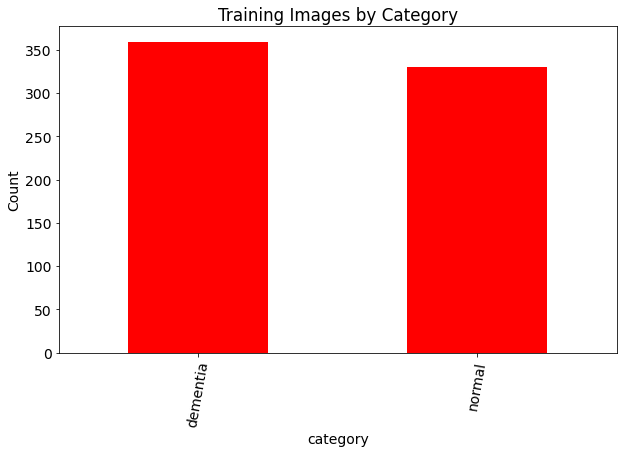

In [5]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(10, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')
plt.show()

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Validation Images by Category')

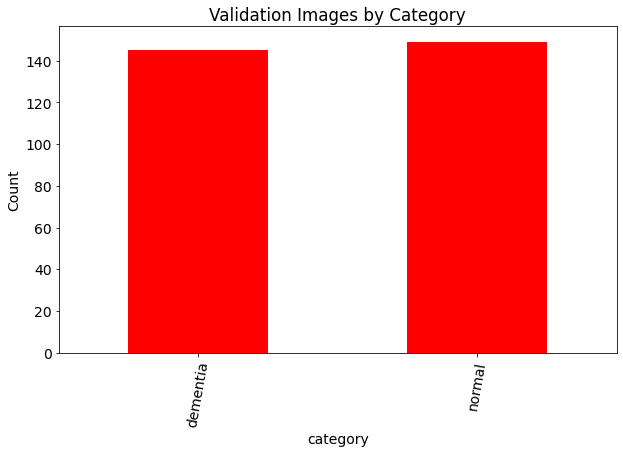

In [6]:
cat_df.set_index('category')['n_valid'].plot.bar(
    color='r', figsize=(10, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Validation Images by Category')

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Test Images by Category')

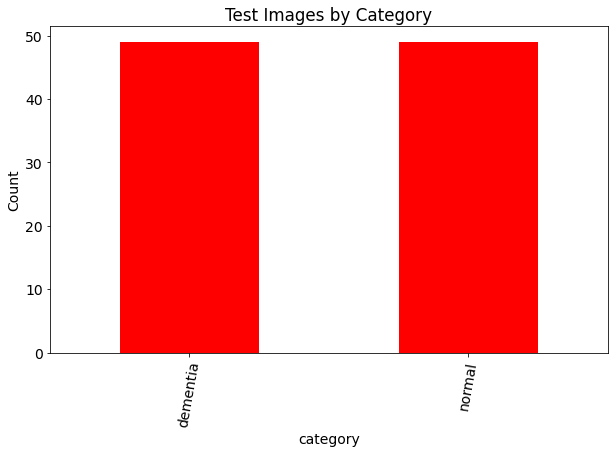

In [7]:
cat_df.set_index('category')['n_test'].plot.bar(
    color='r', figsize=(10, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Test Images by Category')

## Part 2: Image Preprocessing

In [8]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [10]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

## Part 3: Pre-Trained Models for Image Classification
The approach for using a pre-trained image recognition model is well-established:
1.   Load in pre-trained weights from a network trained on a large dataset
2.   Freeze all the weights in the lower (convolutional) layers. Layers to freeze can be adjusted depending on similarity of task to large training dataset
3.   Replace the classifier (fully connected) part of the network with a custom classifier. 
4.   Train only the custom classifier (fully connected) layers for the task

The idea behind pre-training is the early convolutional layers of a cnn extract features that are relevant for many image recognition tasks. The later, fully-connected layers, specialize to the specific dataset by learning higher-level features. Therefore, we can use the already trained convolutional layers while training only the fully-connected layers on our own dataset. Pre-trained networks have proven to be reasonably successful for a variety of tasks, and result in a significant reduction in training time and usually increases in performance.

### Pre-trained Model (vgg16)

In [11]:
model = models.vgg16(pretrained=True)
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Add on Custom Classifier
We'll train a classifier consisting of the following layers

*  Fully connected with ReLU activation (n_inputs, 256)
*  Dropout with 40% chance of dropping
*  Fully connected with log softmax output (256, n_classes)

In [12]:
n_inputs = model.classifier[6].in_features
n_classes = 2
# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [13]:
def get_pretrained_model(model_name):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    return model

In [14]:
model = get_pretrained_model('vgg16')
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 224, 224]           1,792
              ReLU-2         [64, 64, 224, 224]               0
            Conv2d-3         [64, 64, 224, 224]          36,928
              ReLU-4         [64, 64, 224, 224]               0
         MaxPool2d-5         [64, 64, 112, 112]               0
            Conv2d-6        [64, 128, 112, 112]          73,856
              ReLU-7        [64, 128, 112, 112]               0
            Conv2d-8        [64, 128, 112, 112]         147,584
              ReLU-9        [64, 128, 112, 112]               0
        MaxPool2d-10          [64, 128, 56, 56]               0
           Conv2d-11          [64, 256, 56, 56]         295,168
             ReLU-12          [64, 256, 56, 56]               0
           Conv2d-13          [64, 256, 56, 56]         590,080
             ReLU-14          [64, 256,

In [15]:
# Mapping of Classes to Indexes
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'dementia'), (1, 'normal')]

## Part 4: Training Loss and Optimizer


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [17]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):

    # Early stopping intialization
    # Early stopping is an effective method to prevent overfitting on the training data.
    
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [18]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=1) # The result is random

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.4195 	Validation Loss: 0.4620
		Training Accuracy: 79.54%	 Validation Accuracy: 82.31%

Epoch: 1 	Training Loss: 0.3100 	Validation Loss: 0.3755
		Training Accuracy: 88.53%	 Validation Accuracy: 88.10%

Epoch: 2 	Training Loss: 0.2537 	Validation Loss: 0.3400
		Training Accuracy: 89.55%	 Validation Accuracy: 88.10%

Epoch: 3 	Training Loss: 0.2070 	Validation Loss: 0.3175
		Training Accuracy: 92.16%	 Validation Accuracy: 88.44%

Epoch: 4 	Training Loss: 0.2334 	Validation Loss: 0.3271
		Training Accuracy: 89.99%	 Validation Accuracy: 86.73%

Epoch: 5 	Training Loss: 0.2187 	Validation Loss: 0.3166
		Training Accuracy: 90.42%	 Validation Accuracy: 89.12%

Epoch: 6 	Training Loss: 0.2356 	Validation Loss: 0.3149
		Training Accuracy: 90.71%	 Validation Accuracy: 86.39%

Epoch: 7 	Training Loss: 0.1655 	Validation Loss: 0.3113
		Training Accuracy: 93.03%	 Validation Accuracy: 87.41%

Epoch: 8 	Training Loss: 0.1617 	Validation Lo

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

(0.0, 0.5)

Text(0.5, 1.0, 'Training and Validation Losses')

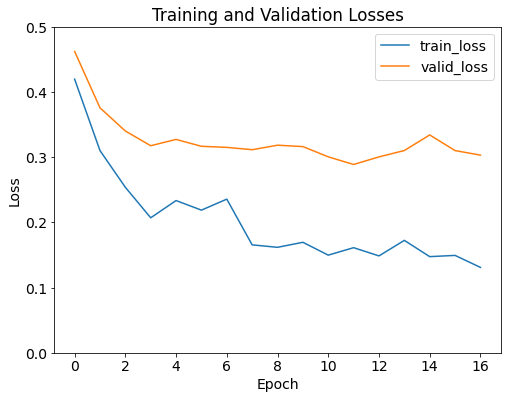

In [31]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,0.5)
plt.title('Training and Validation Losses')

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

(0.7, 1.0)

Text(0.5, 1.0, 'Training and Validation Accuracy')

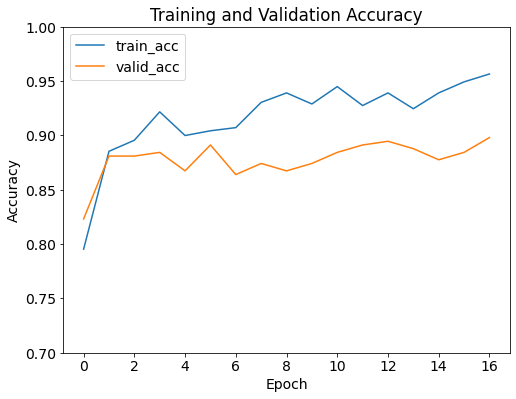

In [20]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7,1)
plt.title('Training and Validation Accuracy')

## Part 5: Test Accuracy

In [21]:
def accuracy(output, target):
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = 1
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))
  
        correct_1 = correct[:1].view(-1).float().sum(0, keepdim=True)
        acc = correct_1.mul_(100.0 / batch_size).item()
        return acc

In [22]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

acc = accuracy(model(features.to('cuda')), targets)
print('Test Accuracy: ',acc)

Test Accuracy:  84.375


## Part 6: Make Prediction

In [23]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [24]:
def predict(image_path, model, topk=5):
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [25]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

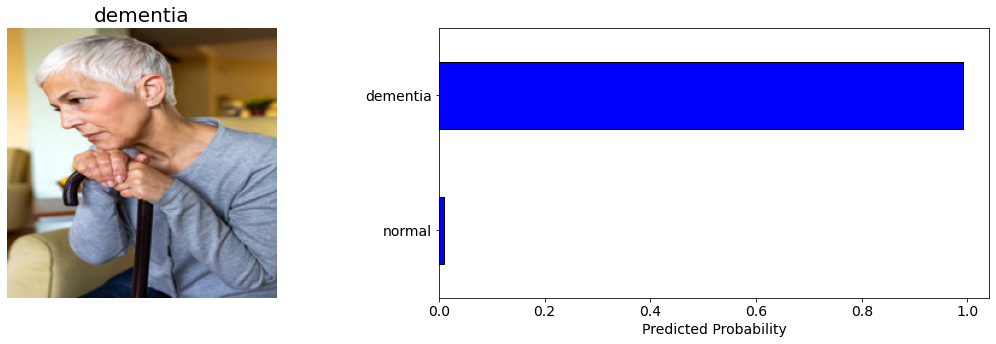

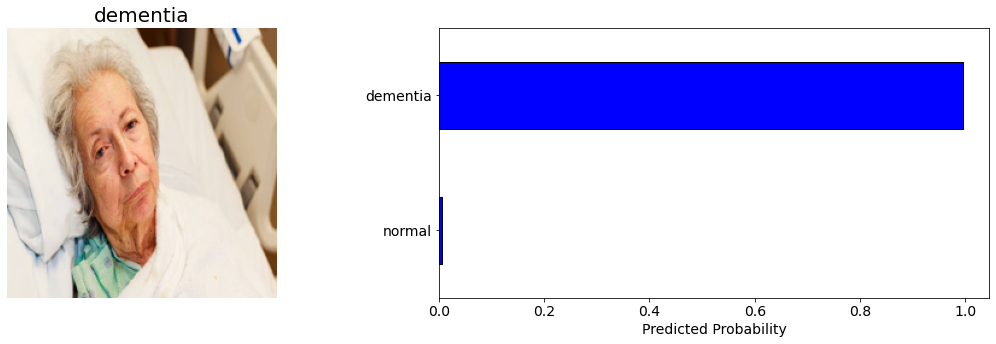

In [26]:
# Test data from dementia class
picture1 = ['1194374633','1197743455']
for pic in picture1:
  image_path = "/content/drive/My Drive/STAT8021/project/dementia_data/test/dementia/istockphoto-"+pic+"-612x612.jpg"
  x = process_image(image_path)
  display_prediction(image_path, model, 2)

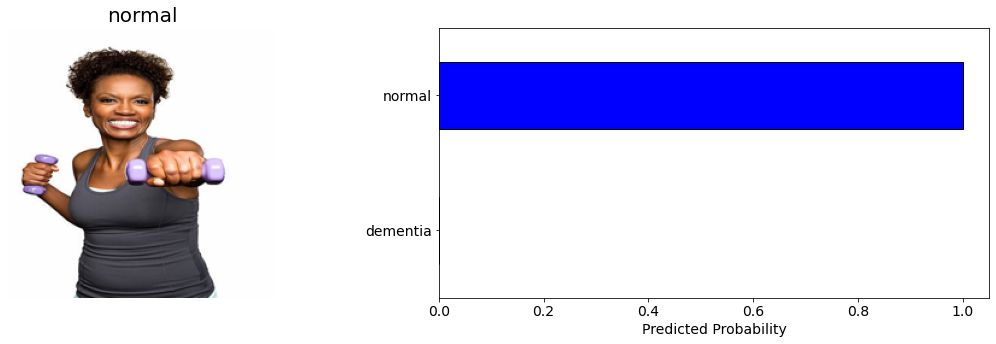

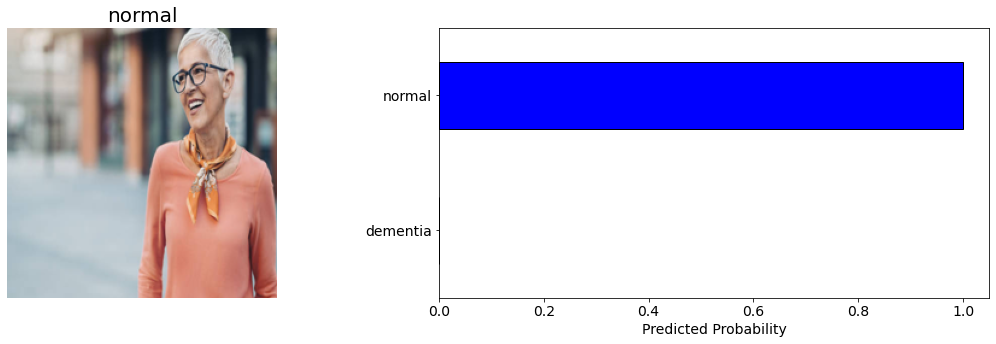

In [27]:
# Test data from normal class
picture2 = ['185290931','1214385230']
for pic in picture2:
  image_path = "/content/drive/My Drive/STAT8021/project/dementia_data/test/normal/istockphoto-"+pic+"-612x612.jpg"
  x = process_image(image_path)
  display_prediction(image_path, model, 2)

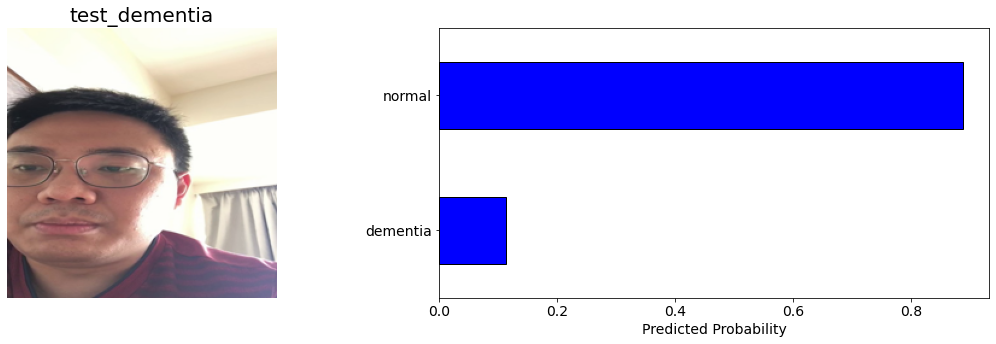

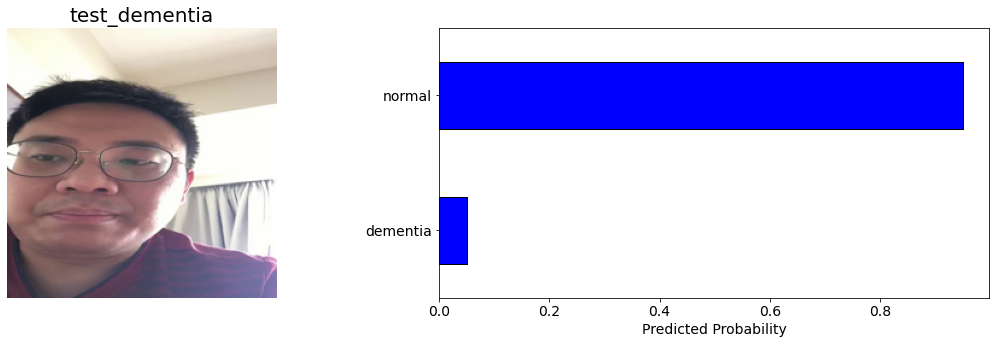

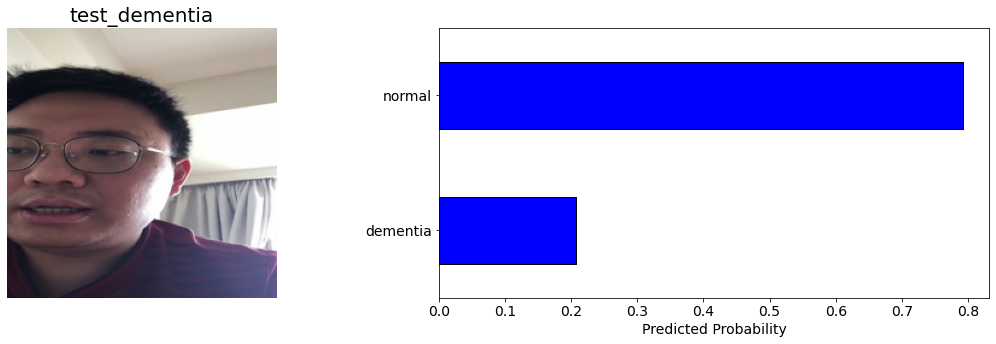

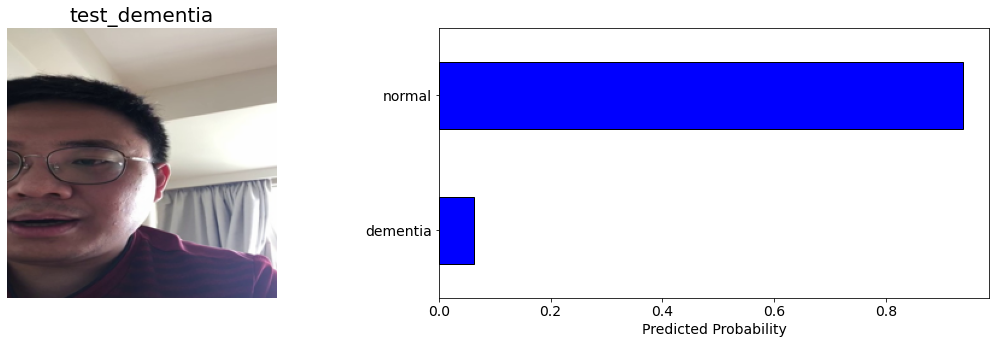

In [28]:
# test for dementia test video
for i in range(1,9,2):
  path = '/content/drive/My Drive/STAT8021/project/figure/test_dementia/image_dem'+str(i)+'.jpg'
  x = process_image(path)
  display_prediction(path, model, 2)

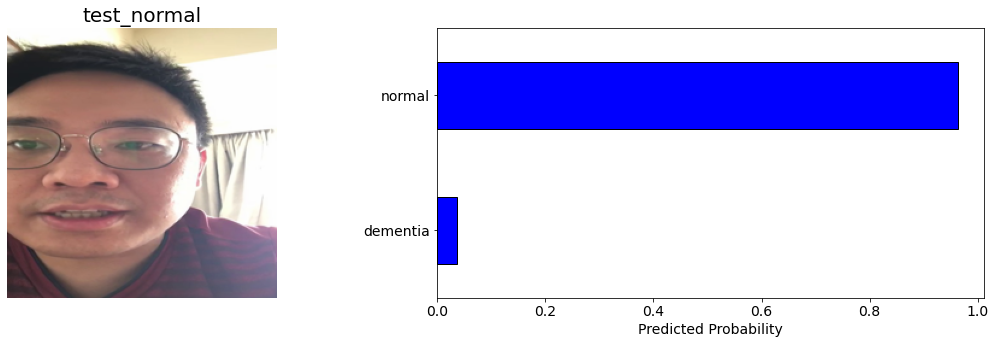

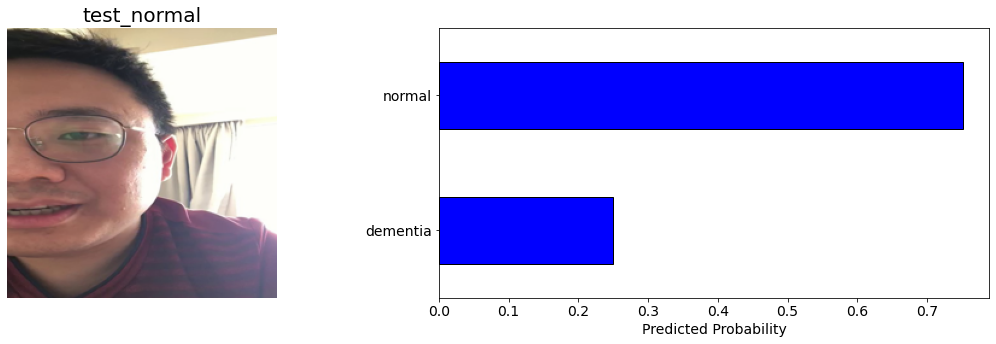

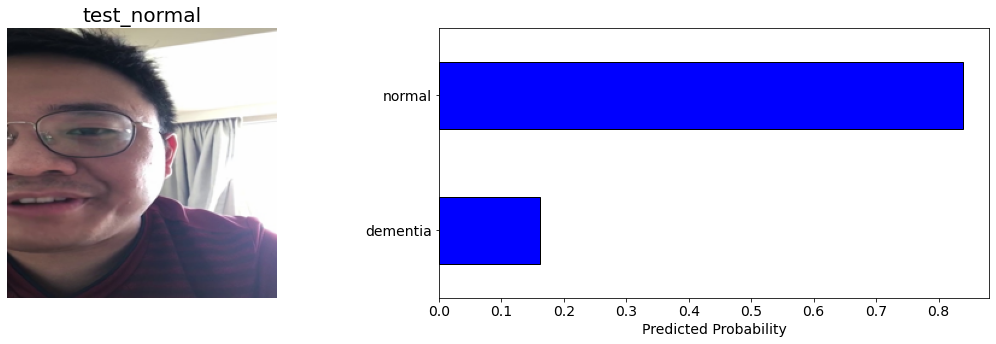

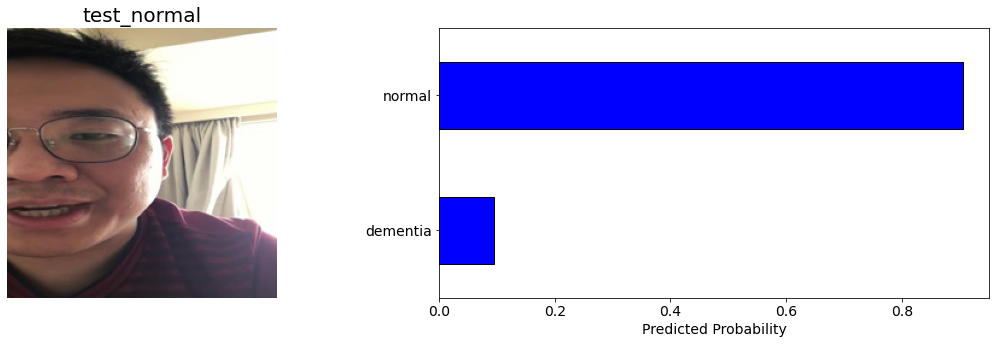

In [29]:
# test for normal test video
for i in range(1,8,2):
  path = '/content/drive/My Drive/STAT8021/project/figure/test_normal/image_nor'+str(i)+'.jpg'
  x = process_image(path)
  display_prediction(path, model, 2)

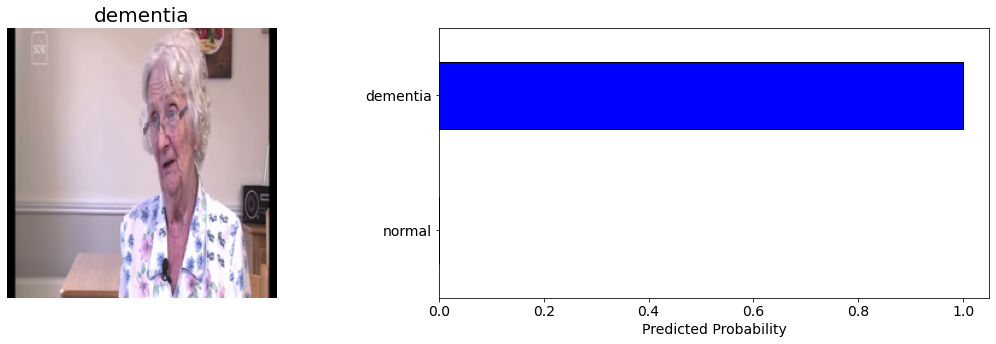

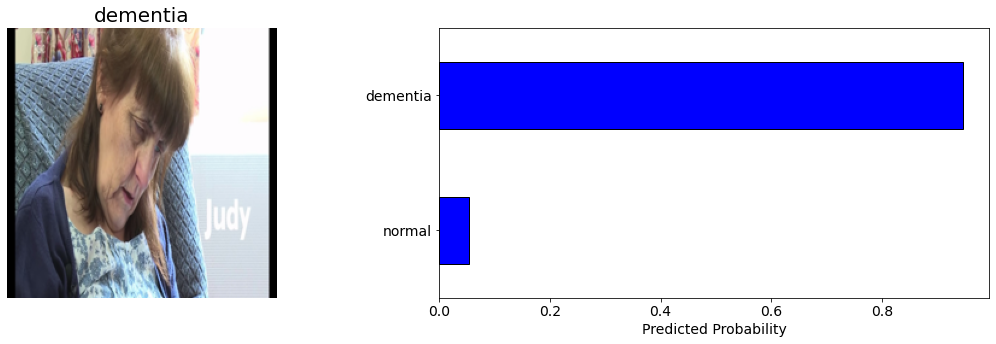

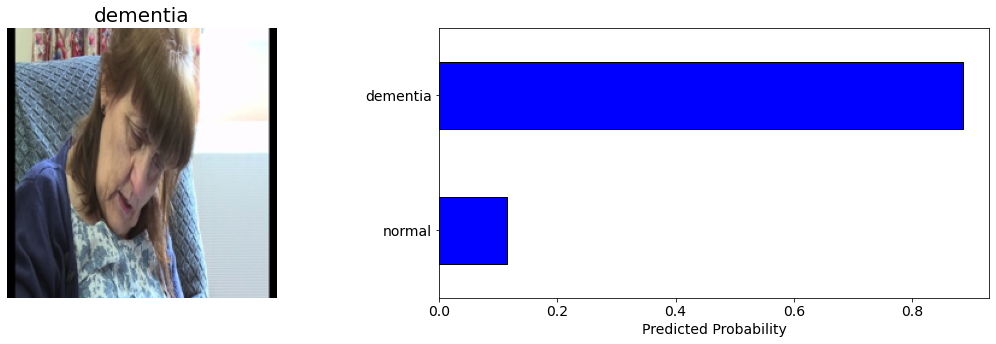

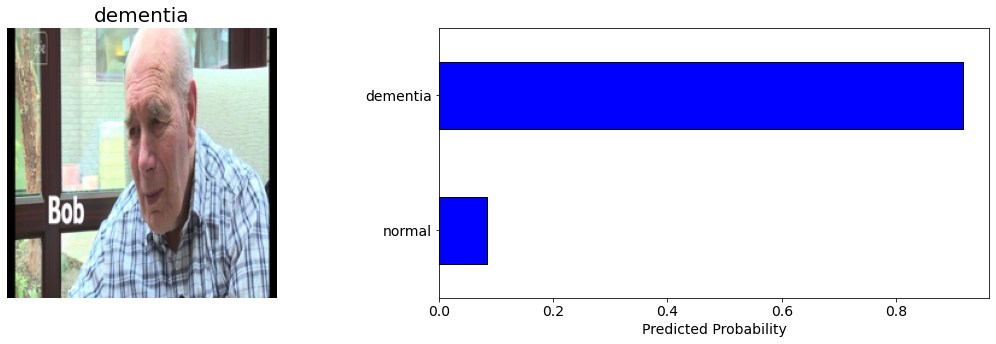

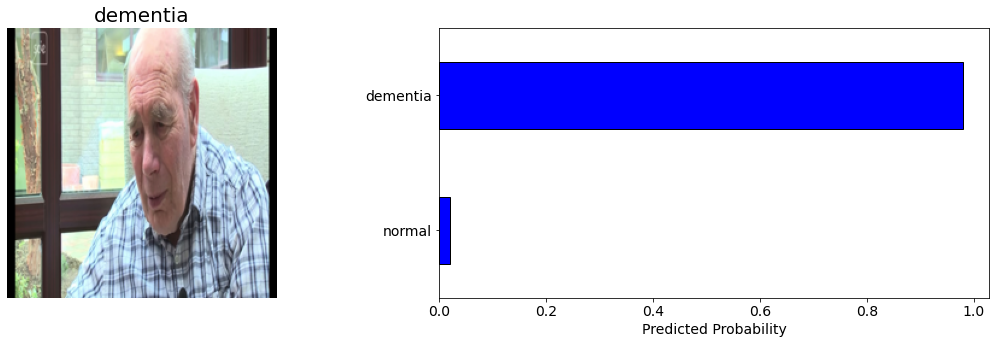

In [30]:
# test for dementia video collected from internet
for i in range(1,10,2):
  path = '/content/drive/My Drive/STAT8021/project/figure/dementia/image_dementia'+str(i)+'.jpg'
  x = process_image(path)
  display_prediction(path, model, 2)